# Neural-network based inversion of magnetotelluric data

In [1]:
import math 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

Define a function that calculates synthetic magnetotelluric data for a layered model. Takes calculation frequencies, layer thicknesses in meters and layer resistivities, returns complex impedace.

In [21]:
def MT1D(frequencies, thicknesses, resistivities):
     Z = 1.0j* np.zeros(len(frequencies))
     for f in range(0,len(frequencies)):      
         freq = frequencies[f]   
         omegamu = -1.0j * math.pi**2 * 8.0e-7 * freq
         sigmacurr = 1.0/ resistivities[len(resistivities)-1]
         kcurr = np.sqrt(omegamu * sigmacurr)
         alpha = 1.0j*np.zeros(len(thicknesses))        
         for index in range(len(resistivities)-2,-1,-1):
                sigmalow = 1.0 / resistivities[index + 1]
                sigmacurr = 1.0 / resistivities[index]
                kcurr = np.sqrt(omegamu * sigmacurr)
                klow = np.sqrt(omegamu * sigmalow)
                if (np.real(kcurr) < 0.0):
                    kcurr = -1.0 * kcurr
                    klow = -1.0 * klow                  
                xi = omegamu * (sigmacurr - sigmalow) / (kcurr + klow)**2
                alpha[index + 1] = (xi + alpha[index + 1]) / (1. + xi * alpha[index + 1])
                alpha[index] = alpha[index + 1] * np.exp(-2. * kcurr * thicknesses[index])
     
         adm = kcurr / (-1.0j * 2. * math.pi * freq) * ((1.- alpha[0]) / (1. + alpha[0]))
         Z[f]= np.conj(1. /adm) * 4.0e-7 * math.pi
     return Z;
 

Create a training dataset and test dataset based on two layer models with known thickness and random resistivities. The data will be the input and the models the reference output for the neural network.

In [22]:
freq = np.array([100, 10, 1, 0.1, 0.01] )
thick = np.array([1000, 10000]    )
def MakeData():

  nsamples = 500
  data = np.zeros([nsamples,2 * freq.size])
  models = np.zeros([nsamples,thick.size])
  for i in range(nsamples):
    res = np.exp(5 * np.random.rand(thick.size))
    models[i,:] = np.log(res)
    Z = MT1D(freq,thick,res)
    data[i,::2] = np.divide(Z.real,  np.sqrt(freq))
    data[i,1::2] = np.divide(Z.imag,  np.sqrt(freq))
    
  ntrain = 400

  inscaler = StandardScaler()
  outscaler = StandardScaler()
  x_train = inscaler.fit_transform(data[:ntrain,:])
  y_train = outscaler.fit_transform(models[:ntrain,:])
  x_test = inscaler.transform(data[ntrain:,:])
  y_test = outscaler.transform(models[ntrain:,:])

  #x_train = data[:ntrain,:]
  #y_train = models[:ntrain,:]
  #x_test = data[ntrain:,:]
  #y_test = models[ntrain:,:]
  return x_train, y_train, x_test, y_test

Plot a sample of the training data and histograms of all inputs and outputs.

## Questions
- What kind of distributions do you observe?
- What implications do these distributions have for training the neural network?

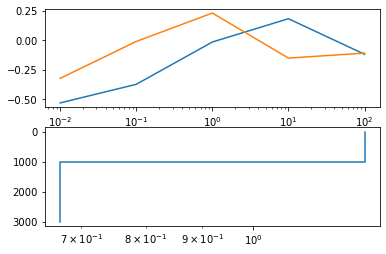

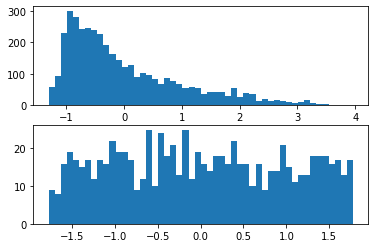

In [23]:
x_train, y_train, x_test, y_test = MakeData()

plt.figure()
plt.subplot(211)
plt.semilogx(freq,x_train[0,::2])
plt.semilogx(freq,x_train[0,1::2])
plt.subplot(212)
plt.semilogx(np.exp([y_train[0,0],y_train[0,0],y_train[0,1],y_train[0,1]]),[0,1000,1000,3000])
plt.gca().invert_yaxis()
plt.show()
plt.figure()
plt.subplot(211)
plt.hist(x_train.flatten(),bins=50)
plt.subplot(212)
plt.hist(y_train.flatten(),bins=50)
plt.show()

Now we create a neural network. The default is a random amalgamation of different activation functions and their associated initializers. The main reason for this is to provide a repository for the different options.

In [51]:
model = keras.Sequential(
    [keras.Input(shape=(x_train.shape[1],)),
     
     #Hidden layers
     layers.Dense(100, activation='selu', kernel_initializer="lecun_normal")  ,
     layers.Dense(100, activation='selu', kernel_initializer="lecun_normal")  ,
     layers.Dense(100, activation='selu', kernel_initializer="lecun_normal")  ,
     layers.Dense(100, activation='selu', kernel_initializer="lecun_normal")  ,
     layers.Dense(100, activation='selu', kernel_initializer="lecun_normal")  ,
     layers.Dense(100, activation='selu', kernel_initializer="lecun_normal")  ,

     layers.Dense(100, activation='relu', kernel_initializer="he_normal")  ,
     #layers.Dense(100, activation='relu', kernel_initializer="he_normal")  ,
     #layers.Dense(100, activation='relu', kernel_initializer="he_normal")  ,
     #layers.Dense(100, activation='relu', kernel_initializer="he_normal")  ,
     #layers.Dense(100, activation='relu', kernel_initializer="he_normal")  ,

     layers.Dense(100, activation=keras.layers.LeakyReLU(alpha=0.3), kernel_initializer="he_normal")  ,
     
     layers.Dense(y_train.shape[1], activation="sigmoid",kernel_initializer="glorot_normal")
     ]
    )

model.summary()
# Call model on a test input

model.compile(optimizer=keras.optimizers.RMSprop(),
              loss=keras.losses.MeanSquaredError())
h = model.fit(x_train, y_train, epochs=100)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 100)               1100      
_________________________________________________________________
dense_43 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_44 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_45 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_46 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_47 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_48 (Dense)             (None, 100)             

13/13 [==============================] - 0s 4ms/step - loss: 0.5202
Epoch 83/100
13/13 [==============================] - 0s 6ms/step - loss: 0.5351
Epoch 84/100
13/13 [==============================] - 0s 6ms/step - loss: 0.5147
Epoch 85/100
13/13 [==============================] - 0s 8ms/step - loss: 0.5069
Epoch 86/100
13/13 [==============================] - 0s 8ms/step - loss: 0.5235
Epoch 87/100
13/13 [==============================] - 0s 4ms/step - loss: 0.5071
Epoch 88/100
13/13 [==============================] - 0s 4ms/step - loss: 0.5095
Epoch 89/100
13/13 [==============================] - 0s 4ms/step - loss: 0.5066
Epoch 90/100
13/13 [==============================] - 0s 7ms/step - loss: 0.5549
Epoch 91/100
13/13 [==============================] - 0s 5ms/step - loss: 0.5423
Epoch 92/100
13/13 [==============================] - 0s 9ms/step - loss: 0.5022
Epoch 93/100
13/13 [==============================] - 0s 5ms/step - loss: 0.5597
Epoch 94/100
13/13 [=====================

Calculate and print the prediction misfit for the test and training data.

In [52]:
etest = model.evaluate(x_train, y_train)
etrain = model.evaluate(x_test, y_test)
print (etest)
print (etrain)


4/4 [==============================] - 0s 3ms/step - loss: 0.5112
0.5322293639183044
0.5112377405166626


Plot the output of the neural network against the true value for each layer. What would indicate a good result?

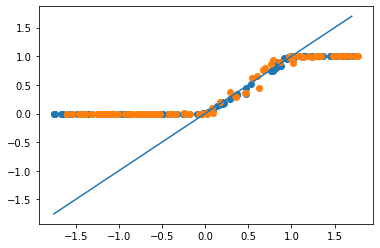

In [53]:
pred = model.predict(x_test)
plt.figure()
plt.scatter(y_test[:,0],pred[:,0])
plt.scatter(y_test[:,1],pred[:,1])
plt.plot([np.min(y_test[:,0]),np.max(y_test[:,0])],[np.min(y_test[:,0]),np.max(y_test[:,0])])
plt.show()

x-axis: expected result  
y-axis: result of NN  
- here output always 1, regardless of input  
- Why? due to saturation of sigmoid function
- normalize via StandardScalar --> which function is called/ how to use it?
    - inscaler.fit_transform(data[:ntrain,:1])

## Tasks
- Prepare the input and output data that it is more amenable to neural network training
- Find the simplest neural network that produces satisfactory results.